In [21]:
# caminhos dos arquivos
hog_path = "C:\\Users\\prodr\\Desktop\\Faculdade\\projeto-5-redes-profundas-projeto-v-produtos-industriais\\data\\Embeddings\\cable\\hog.csv"
lbp_path = "C:\\Users\\prodr\\Desktop\\Faculdade\\projeto-5-redes-profundas-projeto-v-produtos-industriais\\data\\Embeddings\\cable\\lbp.csv"
bnn_path = "C:\\Users\\prodr\\Desktop\\Faculdade\\projeto-5-redes-profundas-projeto-v-produtos-industriais\\data\\Embeddings\\cable\\bnn.csv"

#Importando Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix
from umap import UMAP
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Dicionário com caminhos dos arquivos por embedding
file_paths = {
    "LBP": lbp_path,
    "BNN": bnn_path,
    "HOG": hog_path
}

In [11]:
# Métodos de redução de dimensionalidade a serem aplicados
reductions = {
    "PCA": lambda X: PCA(n_components=2).fit_transform(X),
    "UMAP": lambda X: UMAP(n_components=2, random_state=42).fit_transform(X),
    "TSNE": lambda X: TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42).fit_transform(X)
}

In [12]:
# Lista para armazenar os resultados de Silhouette Score
silhouette_scores = []

# Loop para processar cada tipo de embedding
for emb_name, path in file_paths.items():
    # Carregando o CSV
    df = pd.read_csv(path)

    if "filename" in df.columns:
      # Removendo a coluna "filename"
      df = df.drop(columns= 'filename')

    # Verifica se o CSV contém a coluna 'label'
    if "label" not in df.columns:
        continue

    # Separação entre rótulos e atributos
    labels = df["label"].values
    features = df.drop(columns=["label"]).values

    # Aplicação de PCA prévia para HOG, reduzindo dimensionalidade antes de UMAP e t-SNE
    if emb_name == "HOG":
        features = PCA(n_components=50).fit_transform(features)

    # Loop para aplicar cada método de redução
    for red_name, reducer in reductions.items():
        reduced = reducer(features)  # Reduz as dimensões

        # Criação do DataFrame com os dados reduzidos
        df_reduced = pd.DataFrame(reduced, columns=["x", "y"])
        df_reduced["label"] = labels

        # Salva o resultado em um novo CSV no diretório atual
        output_filename = f"{emb_name}_{red_name}.csv"
        df_reduced.to_csv(output_filename, index=False)

        # Cálculo do Silhouette Score
        score = silhouette_score(features, labels) if len(set(labels)) > 1 else float("nan")
        silhouette_scores.append({
            "Embedding": emb_name,
            "Redução": red_name,
            "Silhouette": score
        })


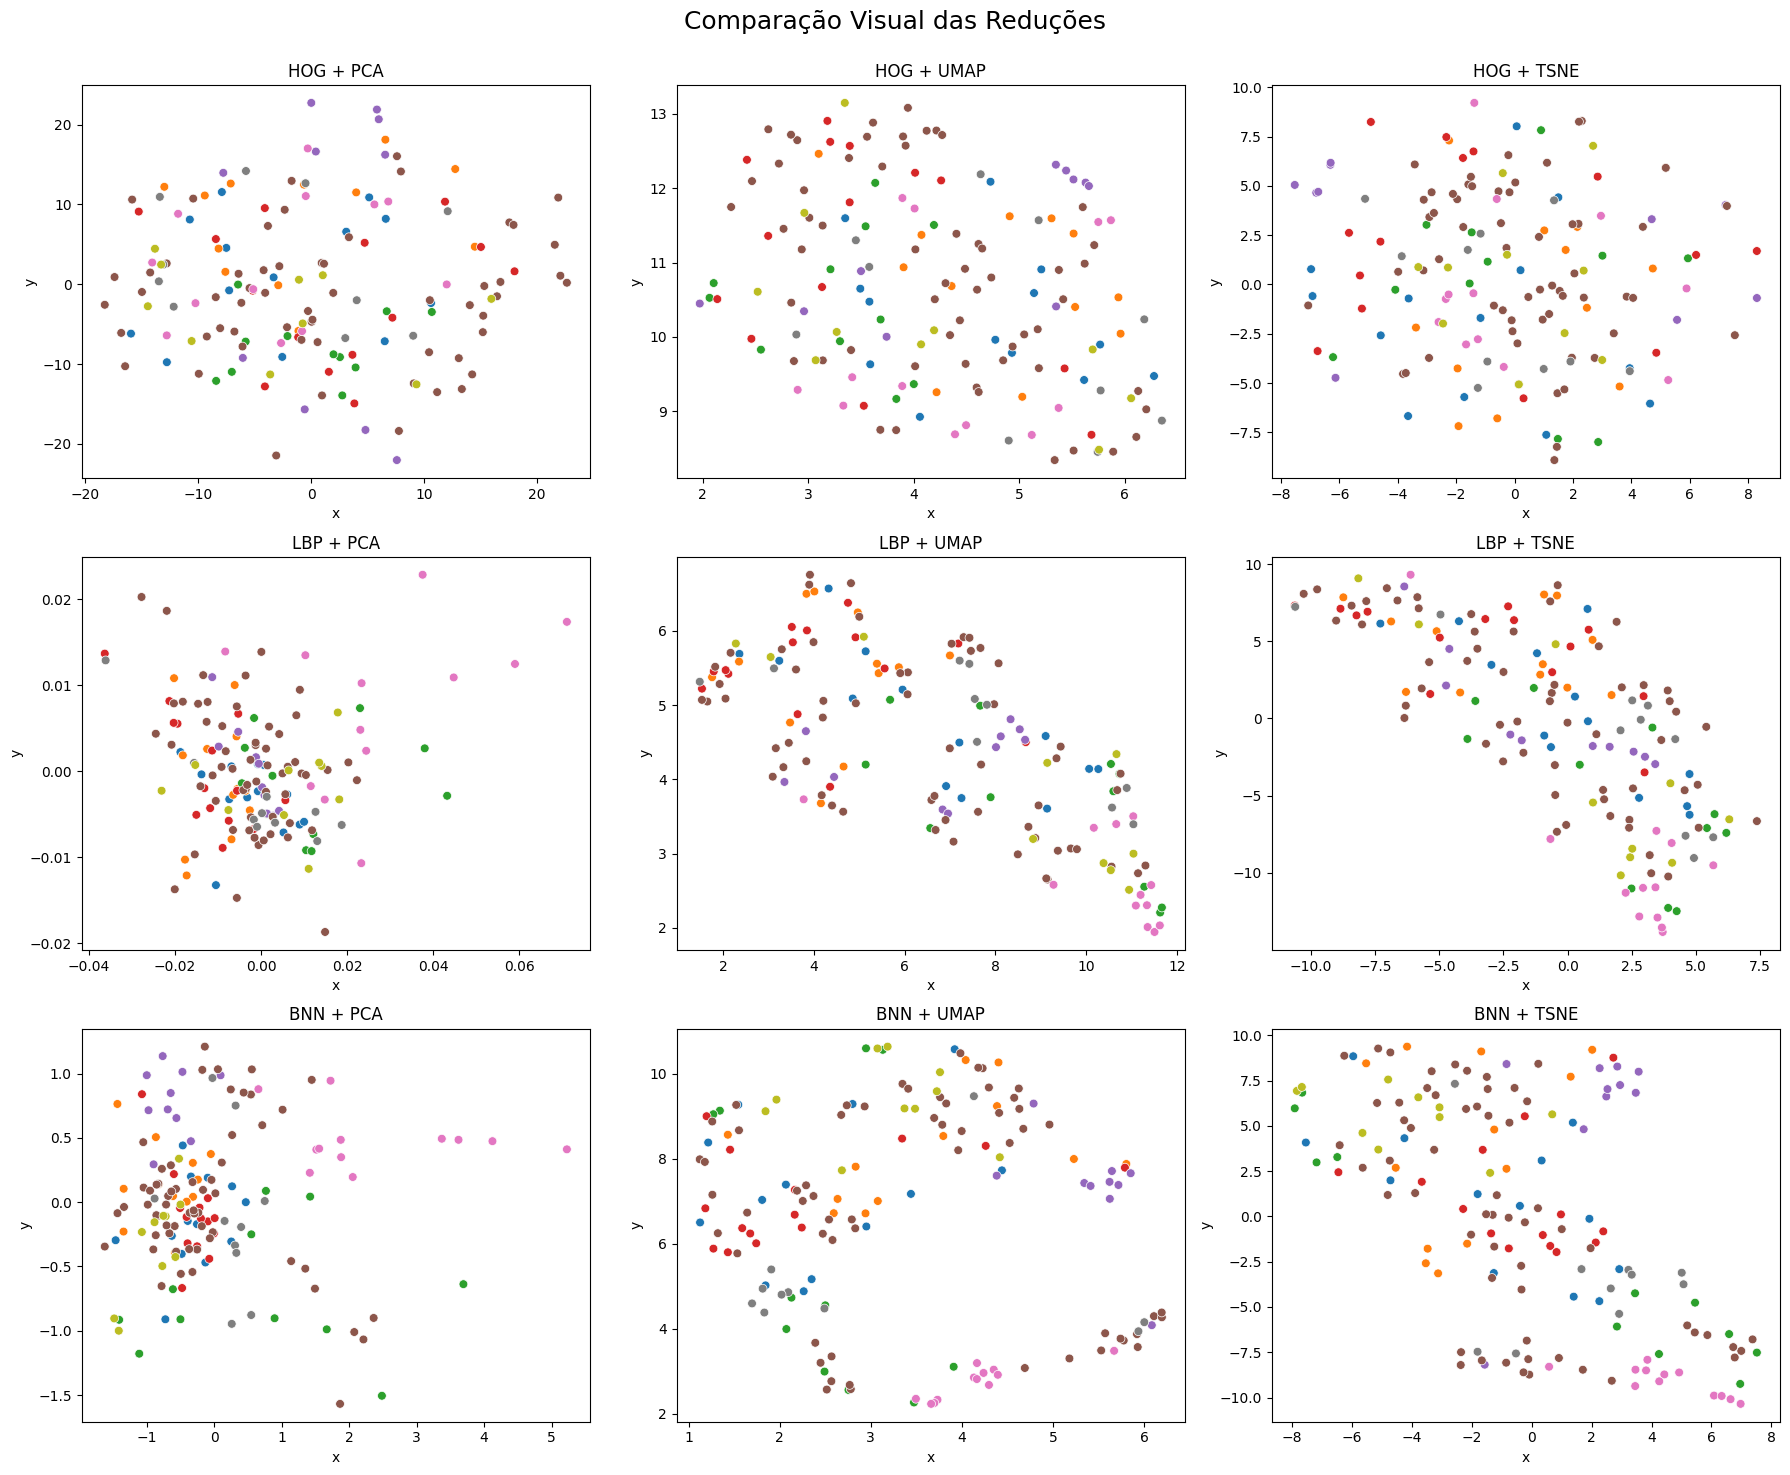

In [13]:
# Nomes dos tipos de embedding e métodos de redução
embedding_names = ["HOG", "LBP", "BNN"]
reduction_names = ["PCA", "UMAP", "TSNE"]


# Criação de figura com 3 linhas e 3 colunas
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Loop para carregar os arquivos reduzidos e gerar os gráficos
for i, emb in enumerate(embedding_names):
    for j, red in enumerate(reduction_names):
        path = f"{emb}_{red}.csv"
        df_plot = pd.read_csv(path)

        # Seleciona o subplot correspondente e plota
        ax = axes[i][j]
        sns.scatterplot(ax=ax, data=df_plot, x="x", y="y", hue="label", palette="tab10", s=40, legend=False)
        ax.set_title(f"{emb} + {red}")

# Ajustes de layout do gráfico
plt.suptitle("Comparação Visual das Reduções", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


In [17]:
# Avaliação dos embeddings com SVM linear
# Lista para armazenar os resultados de acurácia
svm_results = []

# Para cada embedding e cada método de redução, carrega os dados e avalia com SVM
for emb in embedding_names:
    for red in reduction_names:
        file_path = f"{emb}_{red}.csv"
        df = pd.read_csv(file_path)

        # Separação entre atributos e rótulos
        X = df[["x", "y"]].values
        y = df["label"].values

        # Define o classificador SVM linear
        model = SVC(kernel="linear", random_state=42)

        # Validação cruzada (5-fold)
        scores = cross_val_score(model, X, y, cv=5)

        # Armazena os resultados
        svm_results.append({
            "Embedding": emb,
            "Redução": red,
            "Acurácia Média": scores.mean(),
            "Desvio Padrão": scores.std()
        })

In [18]:
# Exibe os resultados da SVM em formato de tabela
df_svm_results = pd.DataFrame(svm_results)
df_svm_results.sort_values(by="Acurácia Média", ascending=False)

,Embedding,Redução,Acurácia Média,Desvio Padrão
5,LBP,TSNE,0.420000,0.026667
8,BNN,TSNE,0.406667,0.090431
4,LBP,UMAP,0.406667,0.024944
0,HOG,PCA,0.386667,0.016330
3,LBP,PCA,0.386667,0.016330
6,BNN,PCA,0.386667,0.074833
1,HOG,UMAP,0.380000,0.026667
2,HOG,TSNE,0.373333,0.024944
7,BNN,UMAP,0.340000,0.090431


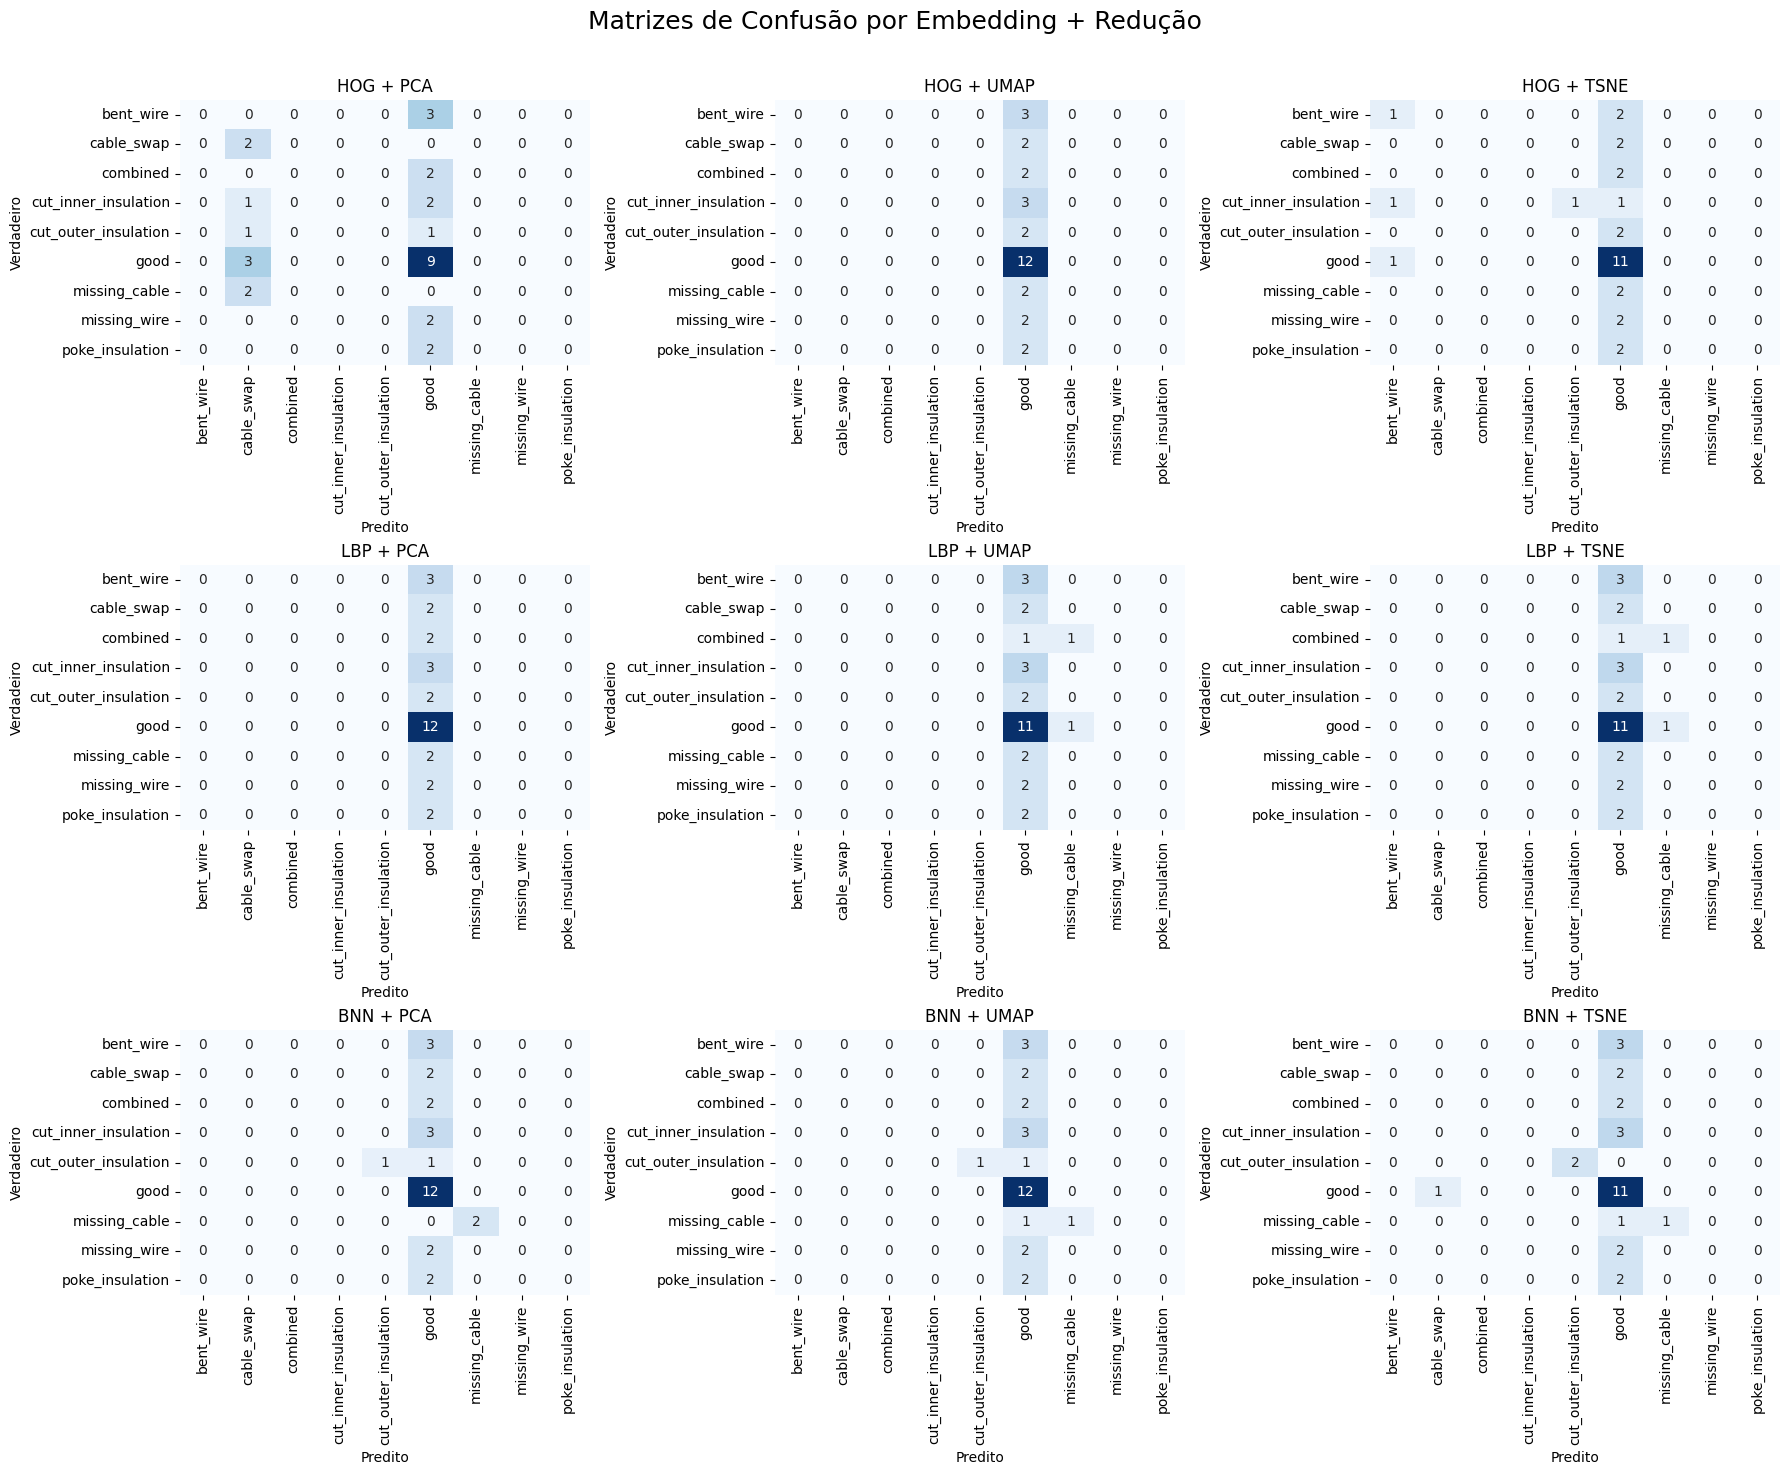

In [22]:
# Grid de matrizes de confusão para todas as combinações (embedding + redução)
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
embedding_names = ["HOG", "LBP", "BNN"]
reduction_names = ["PCA", "UMAP", "TSNE"]

for i, emb in enumerate(embedding_names):
    for j, red in enumerate(reduction_names):
        file_path = f"{emb}_{red}.csv"
        df = pd.read_csv(file_path)

        X = df[["x", "y"]].values
        y = df["label"].values

        # Divisão em treino e teste
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

        # SVM Linear
        model = SVC(kernel="linear", random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Matriz de confusão
        labels = model.classes_
        cm = confusion_matrix(y_test, y_pred, labels=labels)

        ax = axes[i][j]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=labels, yticklabels=labels, ax=ax, cbar=False)

        ax.set_title(f"{emb} + {red}")
        ax.set_xlabel("Predito")
        ax.set_ylabel("Verdadeiro")

plt.suptitle("Matrizes de Confusão por Embedding + Redução", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()
